In [42]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [43]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [44]:
#生成器
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim = z_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(28 * 28 * 1, activation = 'tanh'))
    model.add(Reshape(img_shape))
    return model

In [48]:
#識別器
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [49]:
#コンパイル
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                                    optimizer = Adam(),
                                     metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

In [65]:
losses = []
accs = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train =  np.expand_dims(X_train, axis = 3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        #識別器の訓練
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accurancy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #生成器の訓練
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accs.append(100.0 * accurancy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss: %f, acc : %.2f%%] [G loss %f]" %
                     (iteration + 1, d_loss, 100.0 * accurancy, g_loss))
            
            sample_images(generator)

In [72]:
def sample_images(generator, image_grid_rows = 4, image_gird_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_gird_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                                           image_gird_columns,
                                           figsize = (4,4),
                                           sharey = True,
                                           sharex = True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_gird_columns):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D loss: 0.400272, acc : 85.55%] [G loss 3.813831]
2000 [D loss: 0.334396, acc : 86.33%] [G loss 3.639727]
3000 [D loss: 0.282961, acc : 87.89%] [G loss 2.939476]
4000 [D loss: 0.492707, acc : 77.73%] [G loss 3.269208]
5000 [D loss: 0.384344, acc : 82.03%] [G loss 3.229051]
6000 [D loss: 0.522951, acc : 76.56%] [G loss 3.073086]
7000 [D loss: 0.468727, acc : 80.47%] [G loss 2.770597]
8000 [D loss: 0.500361, acc : 76.17%] [G loss 2.975177]
9000 [D loss: 0.514820, acc : 76.17%] [G loss 2.077170]
10000 [D loss: 0.346520, acc : 84.77%] [G loss 2.570056]
11000 [D loss: 0.355943, acc : 84.77%] [G loss 2.696408]
12000 [D loss: 0.247968, acc : 87.50%] [G loss 2.959102]
13000 [D loss: 0.455377, acc : 78.12%] [G loss 1.992918]
14000 [D loss: 0.430912, acc : 82.42%] [G loss 2.593435]
15000 [D loss: 0.325588, acc : 84.38%] [G loss 3.164495]
16000 [D loss: 0.519129, acc : 76.95%] [G loss 2.490494]
17000 [D loss: 0.317897, acc : 85.16%] [G loss 2.577863]
18000 [D loss: 0.370614, acc : 82.81%] [

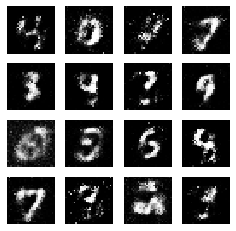

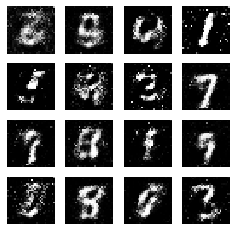

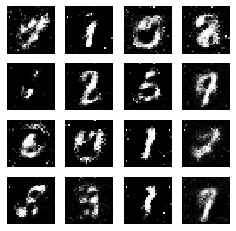

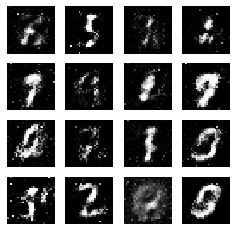

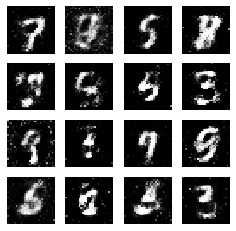

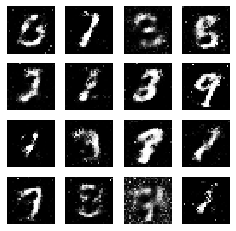

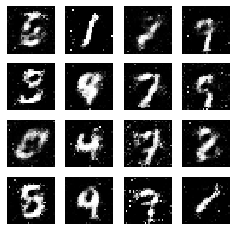

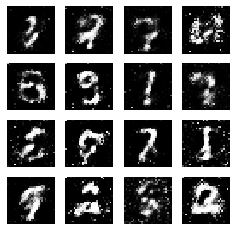

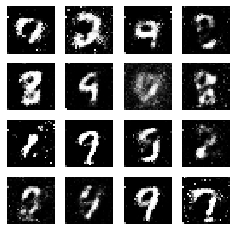

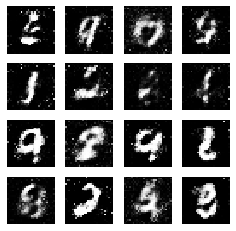

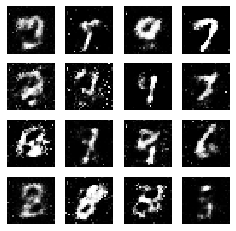

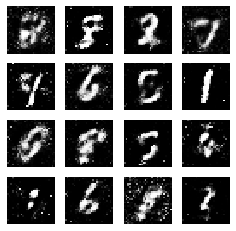

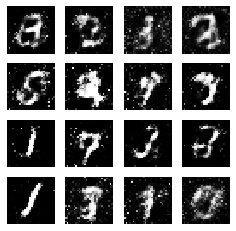

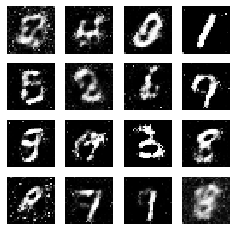

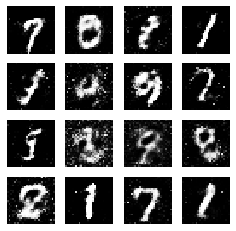

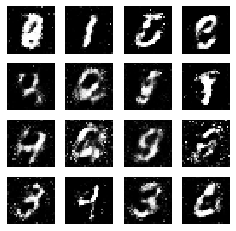

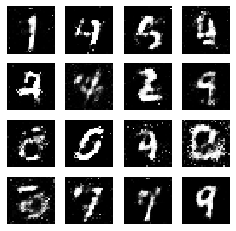

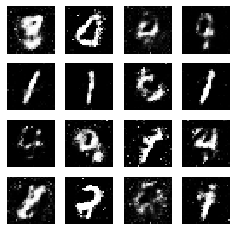

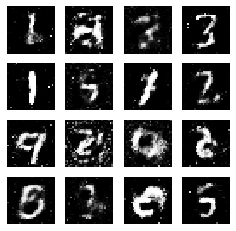

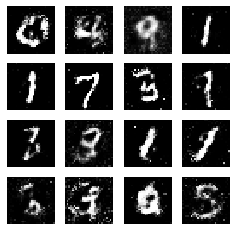

In [73]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)